# Classification Modeling - The Adult Dataset

In this notebook, we will outline how to build a classification model from the adult data set:

https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

This data includes numerous attributes such as age, race, religion, occupation, etc (may of which are cateogrical),
and our goal is to predict if that person makes over $50k or not. 

We begin as always, as including the possible libraries we may need.
    

In [1]:
# Necssary libraries
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits.basemap import Basemap
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import random

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Variable Definitions and Types

These are the definitions of the variables put into the model, and what values they can take on. 
- age: continuous.
-  workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: continuous.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- education-num: continuous.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands."""

# Read in Data 

We begin by reading in the data with the column names specified

In [2]:
colnames=['Age','Workclass','Sector','Education','Education-num','Marital-Status','Occupation','Relationship','Race','Sex','Capital-Gain','Capital-Loss','Hours-Per-Week','Native-Country','y']
df =pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',names=colnames)

Let's take a look at the data

In [272]:
df.head()

,Age,Workclass,Sector,Education,Education-num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-Per-Week,Native-Country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Step 1: Creation of Dummy Variables

As you recall from lecture, for categorical features, we usually have to perform some sort of encoding such
as one-hot encoding. This creates a unique feature for every possibly category the feature has. Otherwise
a linear model won't make sense. We do this with the pandas get_dummies() routine.

In [339]:
df_workclass=pd.get_dummies(df['Workclass'])
df_sector=pd.get_dummies(df['Sector'])
df_education=pd.get_dummies(df['Education'])
df_occupation=pd.get_dummies(df['Occupation'])
df_relationship = pd.get_dummies(df['Relationship'])
df_race = pd.get_dummies(df['Sex'])
df_country=pd.get_dummies(df['Native-Country'])

In [340]:
df_final = pd.concat([df[['Age','Capital-Gain','Capital-Loss']],df_workclass,df_education,df_relationship,df_race,df_country],axis=1)

In [343]:
df_final=df_final.drop(['?'],1)

In [345]:
df_final.shape

(32561, 78)

We convert the $y$ variable into a binary outcome (do they make over 50k or not)

In [279]:
def get_y(y):
    if y.find("<=")>-1:
        return 0
    else:
        return 1

# Step 2: Train and Evaluate the model.

Here we combine many steps into one. We define the functions below:
    
- `run_cv()` takes the data $X$ and outcome $y$ and trains the model using 5 fold cross validation. It returns
the predictions based on using these 5 folds.

- `generate_auc()` uses the probabilities from LogisticRegression to generate the Area Under the Curve of the Receiving Operator Characteristic. 

- `generate_ROCplot()` takes the values returned by `generate_auc` and plots the resulting ROC curve.

Area under the ROC curve : 0.891329


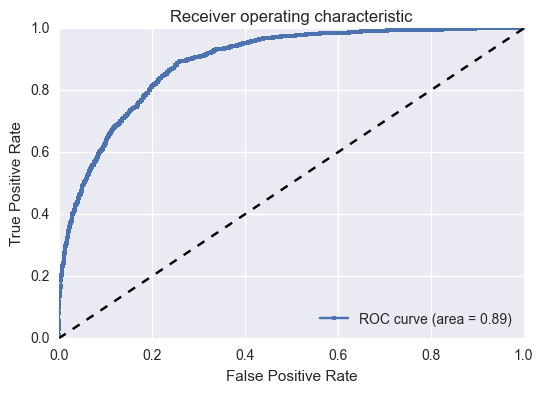

In [9]:
# X are features and y is predictive variable - cancelled HD or not.
X = df_final
y = df['y'].apply(lambda y : get_y(y))

# K-fold cross validation for model selection.
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
   
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred


# Scale columns for regression.
#scaler = StandardScaler()
#X = X.as_matrix().astype(np.float)
#X = scaler.fit_transform(X)

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print "Area under the ROC curve : %f" % roc_auc
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)


The value obtained of 0.89 is very good already. We haven't yet used the cross validation to ensure
generalizability, but did a random split into test/control. We will use cross validation later. 

# Step 3: Correlation of Features

Next we will convert the categorical variables into proper pandas categorical variables, and measure the
correlation of features. Note this is necsesary for pandas to correctly compute correlation between 
categorical/categorical features and cateogircal/continuous. 

In [10]:
cat_features=['Workclass','Education','Marital-Status','Occupation','Relationship','Race','Sex','Hours-Per-Week','Native-Country']

This converts each of the above categorical features into proper category types.

In [11]:
for c in cat_features:
    df[c] = df[c].astype('category')

In [12]:
df.head()

,Age,Workclass,Sector,Education,Education-num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-Per-Week,Native-Country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Next we plot the correlation

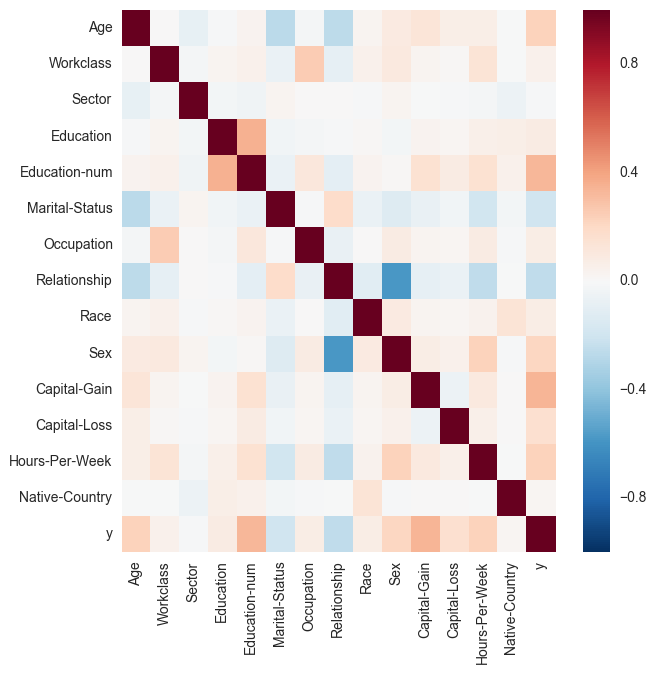

In [13]:
import seaborn as sns
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

for col in df.columns:
    if col != 'age' and col != 'hours_per_week':
        df[col]=le.fit_transform(df[col])

corr = A.corr()
plt.figure(figsize=(7,7))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

We can already see from this plot that various features are correlated such as 

**Positive Correlations:**
- Capital-Gain and $y$ 
- Education-num and $y$
- Workclass and Occupation
- Education-num and Education 


**Negative Correlations:**

- Sex and Relationship
- Age and Relationship
- Marital status and Age


Features like Workclass/Occupation and Education-num/Education are correlated and thus we should
probably just choose one of them, or filter out the weaker performing one via regularization.

# Principal Component Analysis

In [41]:
X_std = StandardScaler().fit_transform(df.drop(['y'],1))

In [42]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.00003071  0.00383117 -0.07846498 -0.01049912  0.03654894 -0.2664369
  -0.02093041 -0.26379096  0.02875255  0.08886551  0.12591969  0.06505979
   0.06912514 -0.00114518]
 [ 0.00383117  1.00003071 -0.01844329  0.02351391  0.05208662 -0.06473323
   0.25489965 -0.09046385  0.0497436   0.09598378  0.02934766  0.01561579
   0.13954485 -0.00769019]
 [-0.07846498 -0.01844329  1.00003071 -0.02706888 -0.04285041  0.03012553
   0.00346883  0.00701633 -0.00897973  0.02575836 -0.0045925  -0.00990327
  -0.01916756 -0.05705011]
 [-0.01049912  0.02351391 -0.02706888  1.00003071  0.35916397 -0.0384081
  -0.02126027 -0.01087644  0.01413168 -0.02735708  0.03138441  0.01611336
   0.05629669  0.06428995]
 [ 0.03654894  0.05208662 -0.04285041  0.35916397  1.00003071 -0.06930622
   0.10970075 -0.09415598  0.03183937  0.01228043  0.15441517  0.08416887
   0.15009869  0.05084153]
 [-0.2664369  -0.06473323  0.03012553 -0.0384081  -0.06930622  1.00003071
  -0.00965407  0.18545667 -0.06801

In [43]:
#Perform eigendecomposition on covariance matrix

cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[  2.88563588e-01   2.29092734e-01  -1.13977040e-01  -4.08816081e-01
   -6.47797012e-02   5.49340838e-01   1.96570034e-01  -3.60303221e-01
    9.66187518e-02  -8.77183958e-02  -1.79743206e-01   1.05937724e-01
   -3.78989862e-01   7.41810525e-02]
 [  2.04255876e-01  -3.54575224e-03   7.68274880e-02   5.36536038e-01
    1.76218758e-01   1.74363362e-03  -7.84522773e-02  -3.48195353e-01
    2.77399537e-02  -6.84657425e-01  -1.03283270e-01  -1.37865517e-01
   -2.51834878e-02  -7.87965090e-02]
 [ -4.59176196e-02  -3.53708193e-04  -1.30045606e-01   1.79848631e-01
    2.59167958e-02   1.29356921e-01   1.14486207e-01   5.08362413e-01
   -2.14546858e-01  -5.49571614e-02  -7.41565878e-01  -7.30943763e-02
   -9.99174096e-02   2.13055998e-01]
 [  1.03955238e-01  -1.29774119e-02   6.06095107e-01  -9.55568078e-02
   -5.79676353e-01  -5.23350159e-02   5.50221946e-02   2.67259093e-01
    2.56866969e-02  -2.08429396e-01   7.93765298e-02  -2.59966155e-01
   -2.78106687e-01  -6.32063020e-02

Next we compute the normalized eigenvalues, sort them and plot.

In [44]:
pca_vals=eig_vals/sum(eig_vals)

In [45]:
pca_vals.sort()

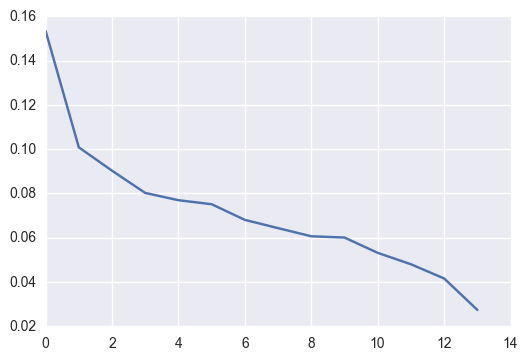

In [46]:
plt.plot(pca_vals[::-1])

In [273]:
pca.explained_variance_ratio_

array([ 0.15344342,  0.10081227,  0.09025488,  0.08022249,  0.07693367,
        0.07511998,  0.06804971,  0.06432211,  0.06064304,  0.06006609,
        0.05316062,  0.04800659,  0.04158462,  0.02738052])

# Reguliarzation

As we did with linear regression, here we will penalize the size of the coefficients by introducuing a constraint. More precisely, we seek to solve
$
\begin{align}
\min_{\beta}- \sum_{k=1}^N &\log p(\mathbf{y_k} | \mathbf{x_k}; \beta)\\
\sum_{m=1}^M |\beta_k|^p &\leq C
\end{align}
$


In [354]:
# X are features and y is predictive variable - cancelled HD or not.
df_final['const']=1
X = df_final
y = df['y'].apply(lambda y : get_y(y))


# Scale columns for regression.
scaler = StandardScaler()
X = scaler.fit_transform(X)

n_samples, n_features = X.shape

half = int(n_samples/2)
X_train, X_test = X[:half], X[half:]
y_train, y_test = y[:half], y[half:]


In [285]:
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc, thresholds

# Lasso Penalization - $L^1$

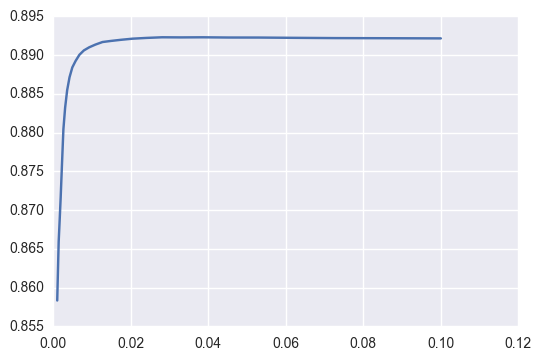

In [355]:
# Create linear regression object
alphas = np.logspace(-3,-1,30)

scores = []

for alpha in alphas:
    regr = LogisticRegression(C=alpha,penalty='l1')

    # Train the model using the training sets
    #regr.fit(X_train, y_train)
    fpr, tpr, roc_auc, thresholds= generate_auc(X,y,LogisticRegression,C=alpha,penalty='l1')
    scores.append(roc_auc)
plt.plot(alphas,scores)
  

In [53]:
regr.score(X_test,y_test)

0.84595540814446291

In [290]:
alpha_best = alphas[np.argmax(scores)]

# Ridge Penalization - $L^2$

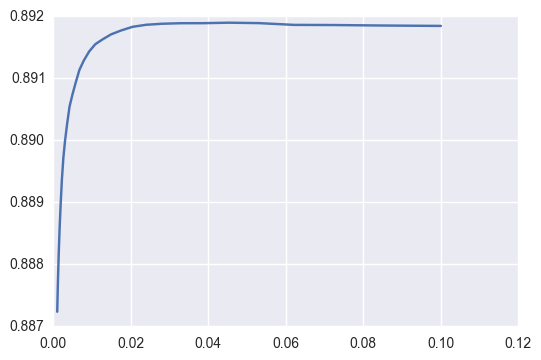

In [288]:
# Create linear regression object
alphas = np.logspace(-3,-1,30)

scores = []

for alpha in alphas:
    regr = LogisticRegression(C=alpha,penalty='l2')

    # Train the model using the training sets
    #regr.fit(X_train, y_train)
    fpr, tpr, roc_auc, thresholds= generate_auc(X,y,LogisticRegression,C=alpha,penalty='l2')
    scores.append(roc_auc)
plt.plot(alphas,scores)
  

# Test/Train regularization plot

In [67]:
alphas = np.logspace(-3,10,30)
enet = LogisticRegression() #C=alpha_best,penalty='l1')
train_errors = list()
test_errors = list()
for alpha in alphas:
    enet = LogisticRegression(C=alpha,penalty='l1') 
    #enet.set_params(alpha=alpha)
    enet.fit(X_train, y_train)
   
    probas_ = enet.predict_proba(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    train_errors.append(roc_auc)
    
    probas_ = enet.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    test_errors.append(roc_auc)

i_alpha_optim = np.argmax(test_errors)
alpha_optim = alphas[i_alpha_optim]
print("Optimal regularization parameter : %s" % alpha_optim)

# Estimat
e the coef_ on full data with optimal regularization parameter
#enet.set_params(alpha=alpha_optim)
#coef_ = enet.fit(X, y).coef_
coef =  LogisticRegression(C=alpha_best,penalty='l1').fit(X,y).coef_

Optimal regularization parameter : 0.0621016941892


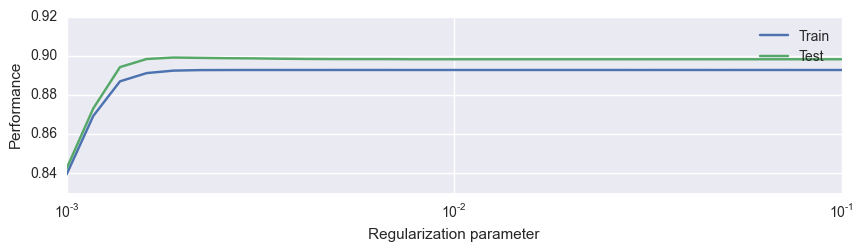

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(2, 1, 1)
plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0.83, 0.92])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')

# Show estimated coef_ vs true coef
#plt.subplot(2, 1, 2)
#plt.plot(coef, label='True coef')
#plt.plot(coef_, label='Estimated coef')
plt.legend()
#plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.26)
plt.show()

# Accuracy as function of percentile

In [496]:
regr = LogisticRegression(C=alpha,penalty='l1')
# Train the model using the training sets
regr.fit(X, y)
probas_ = regr.predict_proba(X)


array([[ 0.03067056,  0.1484529 , -0.21665953, ..., -0.04540836,
        -0.02217266,  0.        ],
       [ 0.83710898, -0.14592048, -0.21665953, ..., -0.04540836,
        -0.02217266,  0.        ],
       [-0.04264203, -0.14592048, -0.21665953, ..., -0.04540836,
        -0.02217266,  0.        ],
       ..., 
       [-0.33589236, -0.14592048, -0.21665953, ..., -0.04540836,
        -0.02217266,  0.        ],
       [-0.84908045, -0.14592048, -0.21665953, ..., -0.04540836,
        -0.02217266,  0.        ],
       [-0.92239303, -0.14592048, -0.21665953, ..., -0.04540836,
        -0.02217266,  0.        ]])

In [521]:
df['prob']=probas_[:,1]
df['Predicted Probability']=df['prob'].apply(lambda x : round(x,1))

In [500]:
df['y']=df['y'].apply(lambda y : get_y(y))

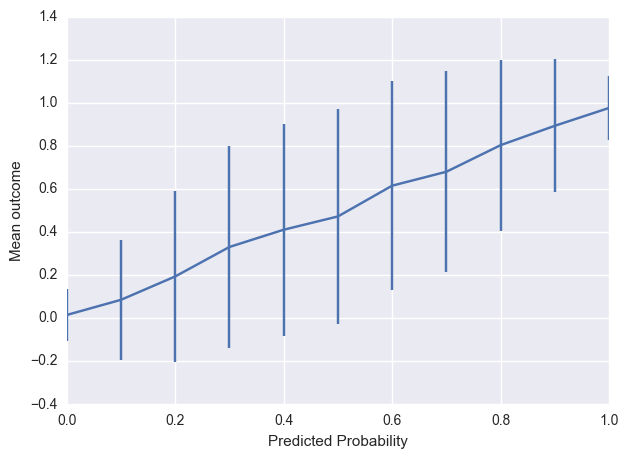

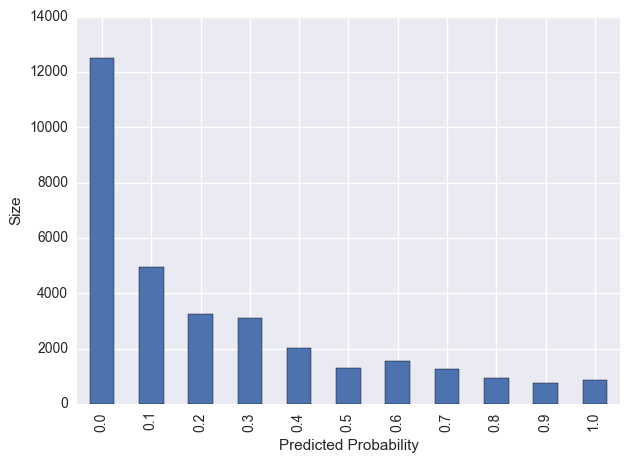

In [526]:
mean_outcome = df.groupby('Predicted Probability')['y'].mean()
size_outcome = df.groupby('Predicted Probability')['y'].size()
std_outcome = df.groupby('Predicted Probability')['y'].std()
plt.ylabel('Mean outcome')
plt.xlabel('Predicted Probability')
mean_outcome.plot(yerr=std_outcome,figsize=(7,5))
plt.show()



size_outcome = df.groupby('Predicted Probability')['y'].size()
plt.ylabel('Size')
size_outcome.plot(kind='bar',figsize=(7,5))
plt.show()

In [512]:
std_outcome

prob_rounded
0.0    0.121426
0.1    0.279560
0.2    0.395470
0.3    0.470641
0.4    0.492149
0.5    0.499451
0.6    0.486578
0.7    0.466490
0.8    0.397144
0.9    0.307964
1.0    0.150206
Name: y, dtype: float64

# Feature Importance

In [304]:
alpha = alphas[np.argmax(scores)]

In [356]:
regr = LogisticRegression(C=alpha,penalty='l1')

# Train the model using the training sets
regr.fit(X_train, y_train)

LogisticRegression(C=0.10000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [456]:
dfCoeffs = pd.DataFrame({'type':df_final.columns.values, 'coef':regr.coef_[0]})

In [309]:
df_reduced = dfCoeffs[(dfCoeffs['coef']>0.1) | (dfCoeffs['coef']<-0.1)]

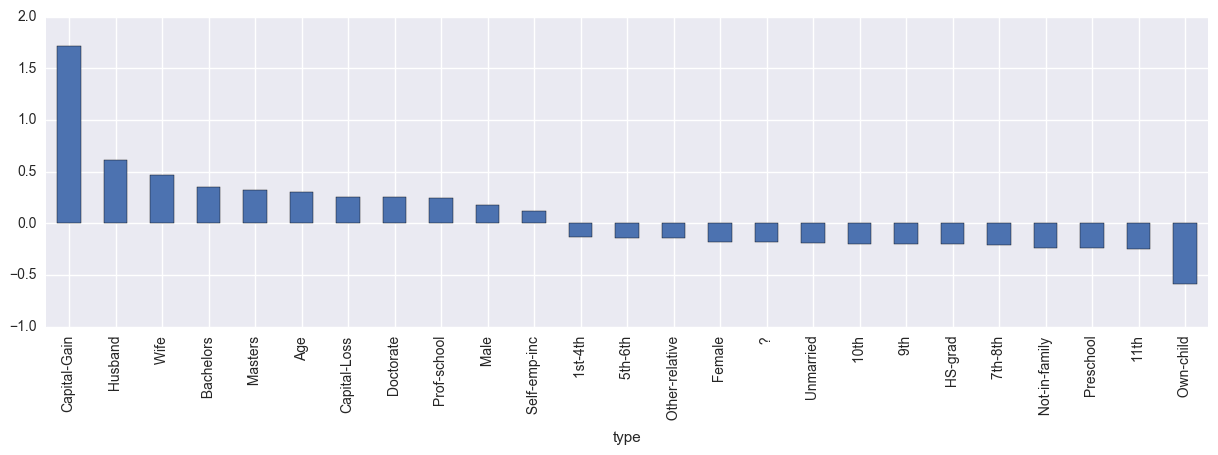

In [569]:
plt.figure(figsize=(15,4
                   ))
dfCoeffs2 = df_reduced.groupby('type')['coef'].mean()
dfCoeffs2.sort()
dfCoeffs2[::-1].plot(kind='bar')

# Variable Confidence 

### P Values

In [360]:
result = sm.OLS( y, X ).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     159.1
Date:                Sun, 12 Feb 2017   Prob (F-statistic):               0.00
Time:                        10:54:13   Log-Likelihood:                -18046.
No. Observations:               32561   AIC:                         3.624e+04
Df Residuals:                   32488   BIC:                         3.685e+04
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0354      0.003     12.789      0.000         0.030     0.041
x2             0.0608      0.002     25.321      0.000         0.056     0.066
x3             0.0396      0.002     16.762      0.000         0.035     0.044
x4            -0.0139      0.002     -6.473      0.000        -0.018    -0.010
x5             0.0154      0.002      6.939      0.000         0.011     0.020
x6            -0.0024      0.002     -1.137      0.256        -0.007     0.002
x7          4.792e-05      0.002      0.020      0.984        -0.005     0.005
x8             0.0051      0.001      3.646      0.000         0.002     0.008
x9             0.0212      0.002      9.523      0.000         0.017     0.026
x10           -0.0144      0.002     -7.004      0.000        -0.018    -0.010
x11           -0.0054      0.002     -2.444      0.015        -0.010    -0.001
x12           -0.0044      0.002     -1.873      0.061        -0.009     0.000
x13           -0.0230      0.002    -10.156      0.000        -0.027    -0.019
x14           -0.0212      0.002     -9.389      0.000        -0.026    -0.017
x15           -0.0099      0.002     -4.274      0.000        -0.014    -0.005
x16           -0.0133      0.002     -5.505      0.000        -0.018    -0.009
x17           -0.0185      0.002     -7.460      0.000        -0.023    -0.014
x18           -0.0298      0.002    -12.890      0.000        -0.034    -0.025
x19           -0.0217      0.002     -9.389      0.000        -0.026    -0.017
x20            0.0021      0.002      0.927      0.354        -0.002     0.007
x21            0.0013      0.002      0.590      0.555        -0.003     0.006
x22            0.0505      0.002     25.560      0.000         0.047     0.054
x23            0.0397      0.002     16.959      0.000         0.035     0.044
x24           -0.0395      0.002    -22.817      0.000        -0.043    -0.036
x25            0.0534      0.002     23.790      0.000         0.049     0.058
x26           -0.0074      0.002     -3.151      0.002        -0.012    -0.003
x27            0.0388      0.002     16.527      0.000         0.034     0.043
x28           -0.0084      0.002     -4.502      0.000        -0.012    -0.005
x29            0.0815      0.002     38.578      0.000         0.077     0.086
x30           -0.0531      0.002    -29.989      0.000        -0.057    -0.050
x31           -0.0157      0.002     -6.888      0.000        -0.020    -0.011
x32           -0.0446      0.002    -20.381      0.000        -0.049    -0.040
x33           -0.0330      0.002    -15.017      0.000        -0.037    -0.029
x34            0.0568      0.002     24.016      0.000         0.052     0.061
x35           -0.0130      0.002     -8.354      0.000        -0.016    -0.010
x36            0.0130      0.002      8.354      0.000         0.010     0.016
x3

In [573]:
dfCoeffs = pd.DataFrame({'type':df_final.columns.values, 'coef':regr.coef_[0]})
dfCoeffs['pvalue']=result.pvalues.values

In [574]:
dfCoeffs=dfCoeffs.drop(dfCoeffs.index[[3]])


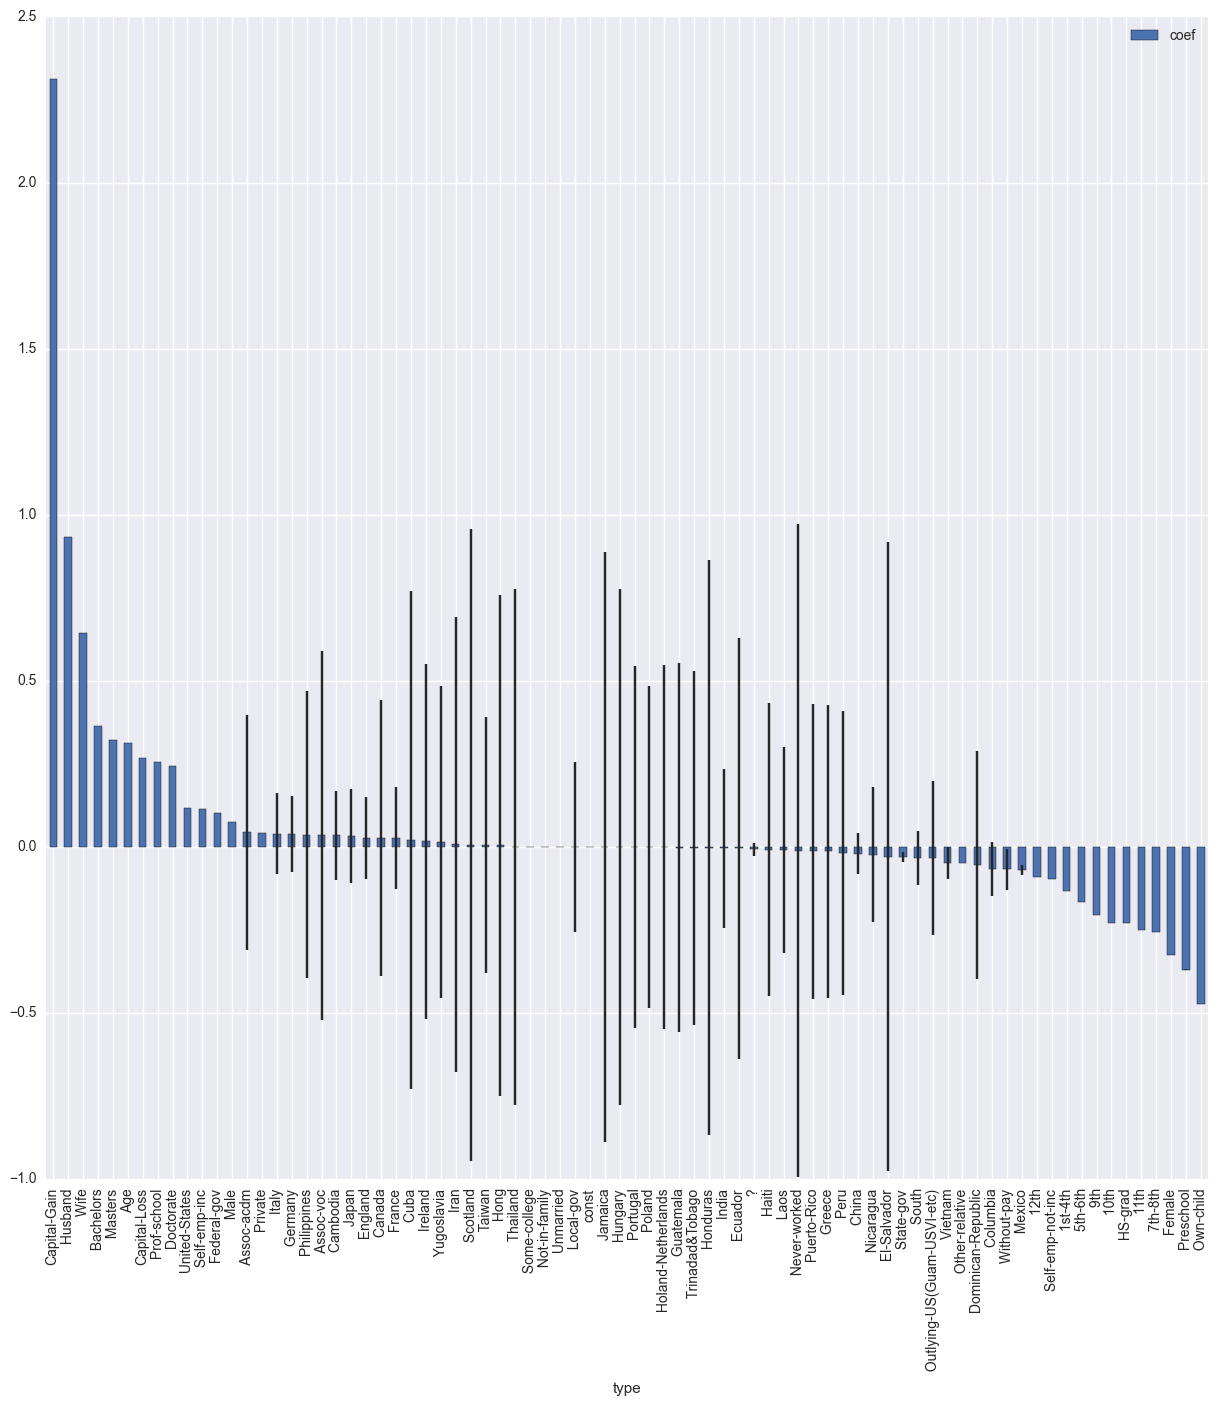

In [577]:
dfCoeffs_sorted = dfCoeffs.sort(['coef'])[::-1]
yerr = dfCoeffs_sorted['pvalue'].values
dfCoeffs_sorted.plot(x='type',y='coef',yerr=yerr,kind='bar',figsize=(15,15))

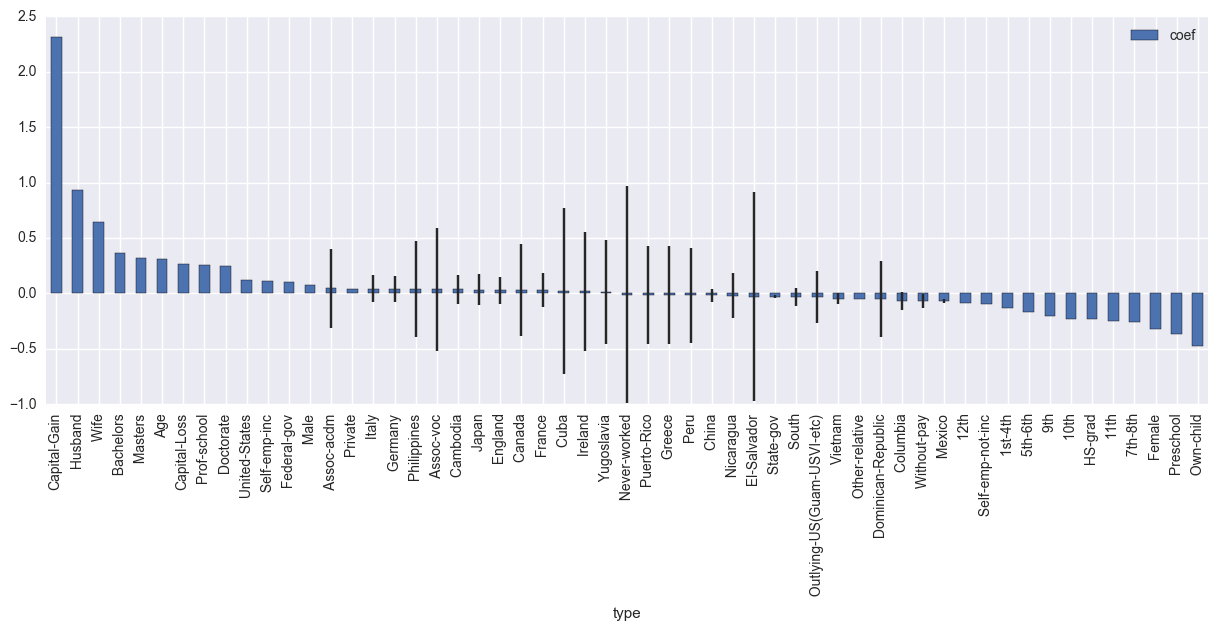

In [578]:
threshold =0.01
dfCoeffs_sorted = dfCoeffs.sort(['coef'])[::-1]
dfCoeffs_sorted_r = dfCoeffs_sorted[(dfCoeffs_sorted['coef']< -threshold) | (dfCoeffs_sorted['coef']> threshold)]
yerr = dfCoeffs_sorted_r['pvalue'].values
dfCoeffs_sorted_r.plot(x='type',y='coef',yerr=yerr,kind='bar',figsize=(15,5))

### Cross validation

In [96]:
from sklearn.linear_model import Ridge

In [399]:
def run_cv_coeffs(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    coeffs=[]
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
        #print clf.coef_[0]
        coeffs.append(clf.coef_)
    return coeffs

coeffs=run_cv_coeffs(X,y,LogisticRegression,C=alpha,penalty='l1')


In [413]:
def get_coeffs(coeffs):
    coeffs_avgd = [(coeffs[0][0][i] + coeffs[1][0][i] + coeffs[2][0][i] + coeffs[3][0][i] + coeffs[4][0][i])/5 for i in range(0,len(df_final.columns))]
    coeffs_std = [np.std([coeffs[0][0][i],coeffs[1][0][i],coeffs[2][0][i],coeffs[3][0][i],coeffs[4][0][i]]) for i in range(0,len(df_final.columns))]
    return coeffs_avgd, coeffs_std
coeffs_avg,coeffs_std=get_coeffs(coeffs)

In [580]:
dfCoeffs = pd.DataFrame({'type':df_final.columns.values, 'coef':coeffs_avg, 'std':coeffs_std})
dfCoeffs=dfCoeffs.drop(dfCoeffs.index[3]) 

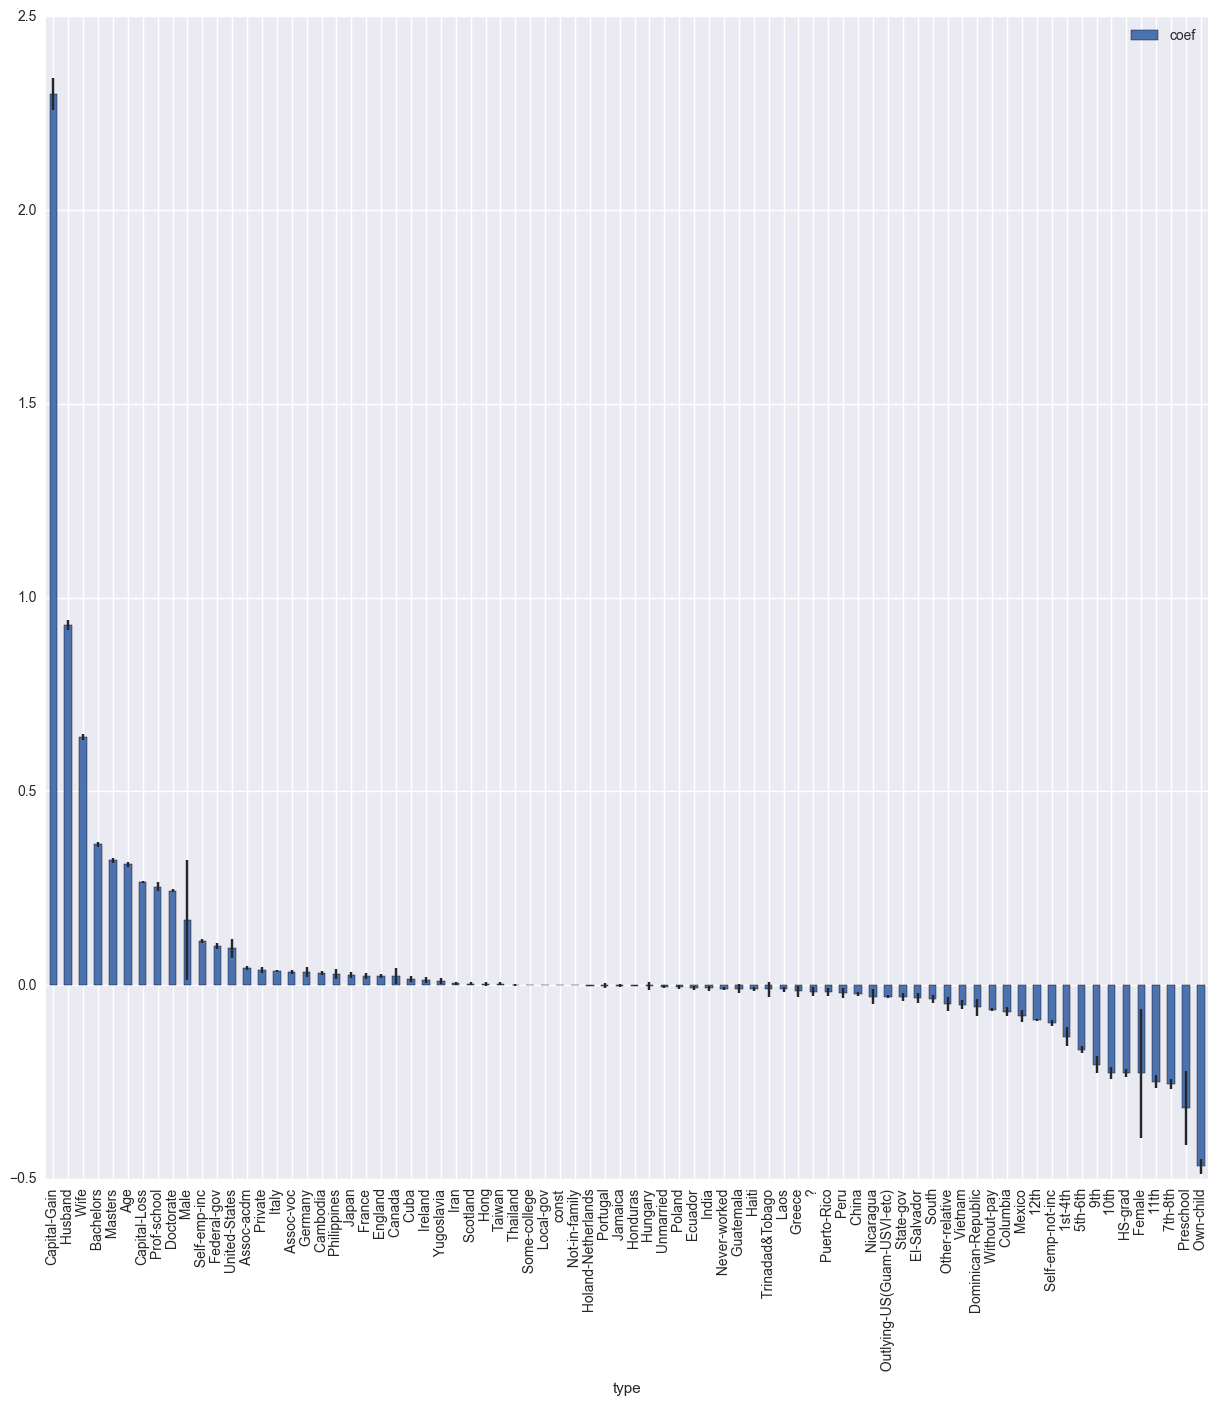

In [581]:
plt.figure(figsize=(15,15))

dfCoeffs_sorted = dfCoeffs.sort(['coef'])[::-1]
yerr_vals = dfCoeffs_sorted['std'].values

dfCoeffs_sorted.plot(x='type',y='coef',kind='bar',yerr=yerr_vals,figsize=(15,15))

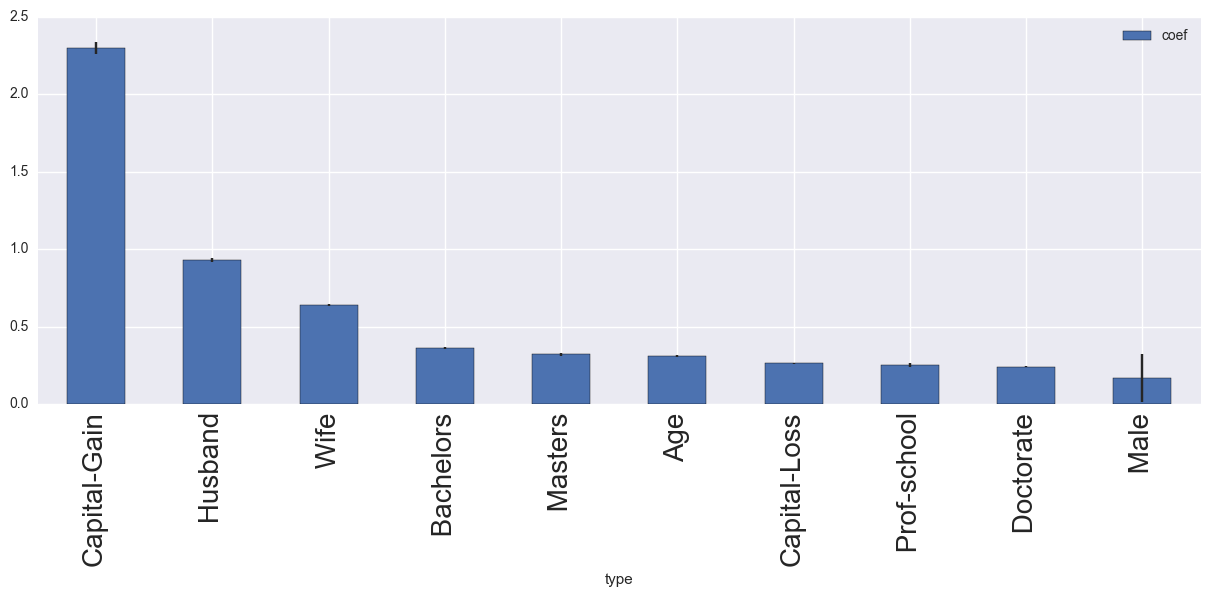

In [594]:
threshold =0.01
dfCoeffs_sorted = dfCoeffs.sort(['coef'])[::-1]
dfCoeffs_sorted_r = dfCoeffs_sorted[(dfCoeffs_sorted['coef']< -threshold) | (dfCoeffs_sorted['coef']> threshold)]
yerr = dfCoeffs_sorted_r['std'].values
plt.rc('xtick', labelsize=20) 
dfCoeffs_sorted_r[0:10].plot(x='type',y='coef',yerr=yerr[0:10],kind='bar',figsize=(15,5))

In [588]:
dfCoeffs.sort(['coef'])[::-1]['type'][0:10].values

array(['Capital-Gain', ' Husband', ' Wife', ' Bachelors', ' Masters',
       'Age', 'Capital-Loss', ' Prof-school', ' Doctorate', ' Male'], dtype=object)

In [591]:
dfCoeffs.sort(['coef'])[::-1]['coef'].apply(lambda x : round(x,2)).values

array([ 2.3 ,  0.93,  0.64,  0.36,  0.32,  0.31,  0.27,  0.25,  0.24,
        0.17,  0.11,  0.1 ,  0.1 ,  0.04,  0.04,  0.04,  0.03,  0.03,
        0.03,  0.03,  0.03,  0.02,  0.02,  0.02,  0.02,  0.01,  0.01,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.  ,
       -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.01, -0.01,
       -0.01, -0.01, -0.01, -0.01, -0.01, -0.02, -0.02, -0.02, -0.02,
       -0.02, -0.03, -0.03, -0.03, -0.03, -0.04, -0.05, -0.05, -0.06,
       -0.06, -0.07, -0.08, -0.09, -0.1 , -0.13, -0.17, -0.2 , -0.23,
       -0.23, -0.23, -0.25, -0.25, -0.32, -0.47])

# AUC ROC

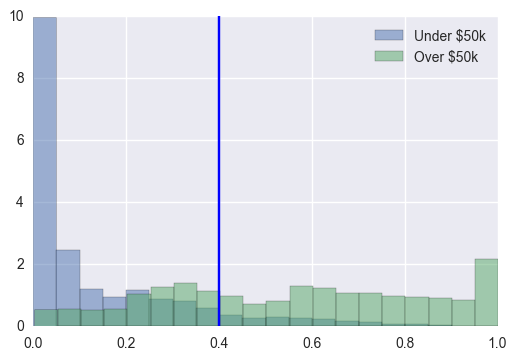

In [537]:
df[df['y']==0]['prob'].hist(bins=20,normed=True,alpha=0.5,label='Under $50k')
df[df['y']==1]['prob'].hist(bins=20,normed=True,alpha=0.5,label='Over $50k')
plt.axvline(0.4)
plt.legend()

[]

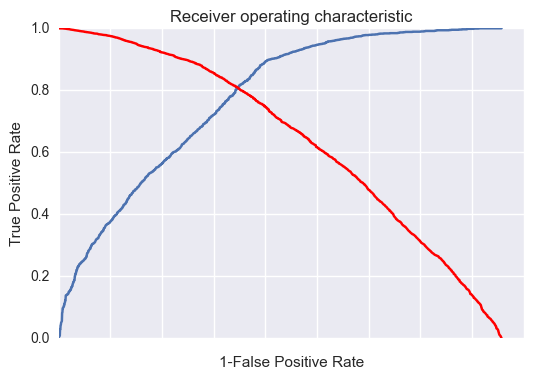

In [540]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.ix[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

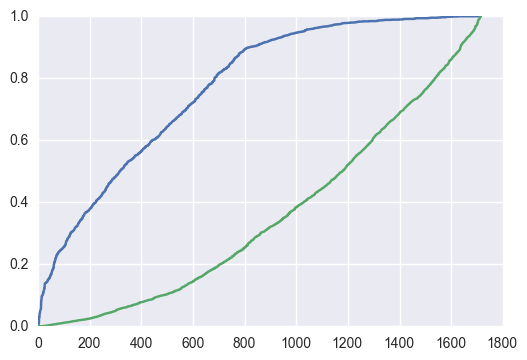

In [550]:
plt.plot(roc['tpr'])
plt.plot(roc['fpr'])

In [ ]:
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])